The second edition of *Think DSP* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# Cacophony

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkDSP2/blob/main/examples/cacophony.ipynb).

In [1]:
import importlib, sys
sys.modules["imp"] = importlib

%load_ext autoreload
%autoreload 2

In [2]:
# download thinkdsp.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ThinkDSP2/raw/main/soln/thinkdsp.py")

This is an example that demonstrates some of the features in the *Think DSP* library.

It is inspired by the performance of a grade school band I witnessed recently.  My goal is to simulate the sound of a beginner band.

First, a function that translates from a MIDI number to a frequency:

In [3]:
def midi_to_freq(midi_num):
    """Converts MIDI note number to frequency.

    midi_num: int MIDI note number
    
    returns: float frequency in Hz
    """
    x = (midi_num - 69) / 12.0
    freq = 440.0 * 2**x
    return freq

Now here's a randomized version that simulates three kinds of errors: poor tuning, playing the wrong note, and [popping an overtone](https://en.wikipedia.org/wiki/Overtone).  Notice that it is possible to make all three errors.

In [4]:
import random

def random_freq(midi_num):

    # simulate poor tuning by adding gaussian noise to the MIDI number
    midi_num += random.gauss(0, 0.5)
    
    # one kid out of 10 plays the wrong note
    if random.random() < 0.1:
        midi_num += random.randint(-5, 5)
        
    freq = midi_to_freq(midi_num)
    
    # and one kid in 10 pops an overtone
    if random.random() < 0.1:
        freq *= random.randint(2, 5)

    return freq

This function takes a MIDI number and duration and makes a Wave:

In [5]:
from thinkdsp import SawtoothSignal

def make_note(midi_num, duration, framerate=22050):
    """Make a MIDI note with the given duration.

    midi_num: int MIDI note number
    duration: float seconds
    sig_cons: Signal constructor function
    framerate: int frames per second

    returns: Wave
    """
    freq = random_freq(midi_num)
    signal = SawtoothSignal(freq)
    wave = signal.make_wave(duration, framerate=framerate)
    wave.apodize()
    return wave

Let's test make_note.  MIDI number 60 is middle C.

In [6]:
note = make_note(60, 1.0)
note.make_audio()

Sounds good.

Now we can make 10 notes and play them at the same time.  Since Wave provides `__add__`, we can use `sum`:

In [7]:
def make_ensemble(midi_num, duration):
    notes = [make_note(midi_num, duration) for i in range(10)]
    ensemble = sum(notes)
    ensemble.make_audio()
    return ensemble

And we can test it with a middle C:

In [8]:
c = make_ensemble(60, 1.0)
c.make_audio()

Good, sounds like angry bees.

And now, a rousing chorus of that old crowd favorite, _Hot Cross Buns_.

Wave provides `__or__`, which concatenates notes, so we can use `reduce`:

In [9]:
from thinkdsp import Wave
from functools import reduce

midi_nums = [64, 62, 60,     64, 62, 60,    60, 60, 60, 60,      62, 62, 62, 62,      64, 62, 60]
durations = [0.5, 0.5, 1.0,  0.5, 0.5, 1.0, 0.25, 0.25, 0.25, 0.25,  0.25, 0.25, 0.25, 0.25,  0.5, 0.5, 1.0]

waves = [make_ensemble(midi_num, duration) for midi_num, duration in zip(midi_nums, durations)]
wave = reduce(Wave.__or__, waves)
wave.make_audio()

And that brings a tear of pride to any parent's eye.

On a more serious note, this example tells us something about how the ear interprets complex sounds with many tones and harmonics.

Let's take a look at the spectrum of that middle C:

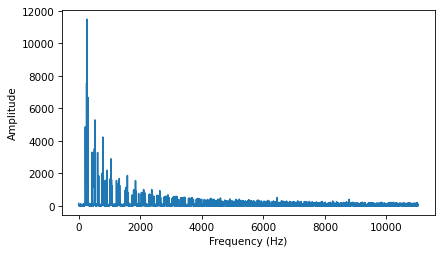

In [10]:
from thinkdsp import decorate

spectrum = c.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

And we can zoom in on the first few harmonics:

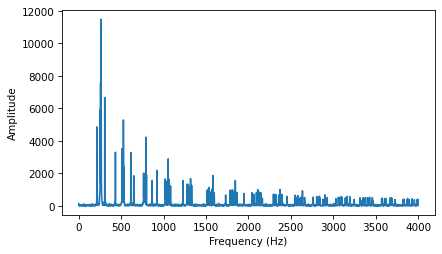

In [11]:
spectrum.plot(high=4000)
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

A few observations: 

1. The kids playing out of tune have a bigger effect on the harmonics, and less effect on the fundamental, so the ear can still pick out a clear pitch, and

2. Some of the unintentional overtones overlap with the harmonics, so they change the timbre, but don't stick out as much as you might expect, 

3. The high harmonics are so spread out that they basically contribute white noise and don't affect the perceived pitch.

[Think DSP: Digital Signal Processing in Python, 2nd Edition](https://allendowney.github.io/ThinkDSP2/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)